# 2.4.1 종목 코드 추출하기

In [2]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np

# 거래소 전체 추출 (코스피, 코스닥 대상) 
df = fdr.StockListing('KRX').query("Market in ['KOSPI', 'KOSDAQ']")

# 종목별 종가(Close) 문자형에서 수치형(integer)으로 변환
df['Close'] = df['Close'].astype(int) 

In [4]:
# 소형주: 시가총액 1,000억 원 미만 종목 제외 적용  
df = df.query(" Marcap >= 100000000000 ")

# 저유동성 : 일 거래량 2,000주 미만 제외 적용 
df = df.query(" Volume >= 2000 ")

# 동전주: 높은 변동성 위험을 고려하여 주가 1,000원 미만 종목 제외 적용 
df = df.query(" Close >= 1000 ")

# 우선주: 낮은 거래량과 본주와의 주가 차이(괴리율)로 인한 분석의 한계로 제외 (종목코드 끝자리 5,7,9,K) 적용 
df = df[ df['Code'].apply(lambda x: False if x[-1] in ['5','7','9','K'] else True) ]

# 스팩(SPAC), 리츠, 벤처투자 등 : 재무 데이터의 실효성이 없어 제외 적용 
df = df[ ~df['Name'].str.contains('스팩|리츠|리얼티|인프라|유전|벤처') ]

# 데이터프레임 인덱스 초기화 
df = df.reset_index(drop=True) 

# 최종 종목 추출 건수 출력 
print(len(df)) 


1328


In [5]:
# 종목 정보 사전 저장 
stock_list = dict(zip(df['Code'], df['Name']))

# (참고) 수집 결과 출력 (최초 5건)
print("분석대상 기업 건수 ", len(stock_list))
print("최초 5건 출력 : ")
for i, (k, v) in enumerate(stock_list.items()):
    if i <= 4:
        print(k, v)

분석대상 기업 건수  1328
최초 5건 출력 : 
005930 삼성전자
000660 SK하이닉스
207940 삼성바이오로직스
373220 LG에너지솔루션
005380 현대차


In [ ]:
# 파일 저장에 필요한 라이브러리 호출
import pickle

# 1. 파일 저장
with open('멀티팩터_전체종목_stock_list.pkl', 'wb') as f:
    pickle.dump(stock_list, f)

# 2. 파일 불러오기
with open('멀티팩터_전체종목_stock_list.pkl', 'rb') as f:
    stock_list = pickle.load(f)


# 2.4.2 종합지표 생성하기

In [6]:
def get_momentum(scode, SD, ED):
    """    
    주가 모멘텀과 거래량 모멘텀 계산 

    매개변수: 
         scode : 종목 코드 (예: '005930')
         SD : 주가데이터 추출시작일 (예: '20250102')
         ED : 주가데이터 추출종료일 (예: '20250131')

    반환값: 
        avg : 주가 모멘텀 지표 (기간별 수익률 평균)
        vol : 거래량 모멘텀 지표 
    """

    # 1. 주가 및 거래량 데이터 수집 (여기는 에러나면 멈춰서 확인해야 하므로 try-except 제거)
    df = fdr.DataReader(scode, SD, ED)

    # 2. 주가 모멘텀 지표 생성
    # 단기 (1일, 1주, 1개월) - 데이터가 너무 없으면 에러가 나는 게 맞으므로 그대로 둠
    mom_1d = ( df.iloc[-1]['Close'] / df.iloc[-2]['Close'] - 1 )  * 100    # 전일
    mom_1w = ( df.iloc[-1]['Close'] / df.iloc[-5]['Close'] - 1 )  * 100    # 주간
    mom_1m = ( df.iloc[-1]['Close'] / df.iloc[-20]['Close'] - 1 )  * 100   # 월간 

    # 3개월간 (데이터 부족 시 NaN 처리)
    try:
        mom_3m = ( df.iloc[-1]['Close'] / df.iloc[-60]['Close'] - 1 )  * 100 
    except:
        mom_3m = np.nan

    # 연간 (데이터 부족 시 NaN 처리)
    try:
        mom_1y = ( df.iloc[-1]['Close'] / df.iloc[-240]['Close'] - 1 )  * 100
    except:
        mom_1y = np.nan

    # 3. 기간별 수익률의 평균 계산 (NaN을 제외하고 평균 산출)
    avg = np.nanmean([mom_1d, mom_1w, mom_1m, mom_3m, mom_1y])

    # 4. 거래량 모멘텀 지표 생성
    try:
        vol_short = df['Volume'].rolling(window=5).mean().iloc[-1]  # 최근 5일
        vol_long = df['Volume'].rolling(window=20).mean().iloc[-1]  # 최근 20일
        vol = ( vol_short / vol_long - 1) * 100
    except:
        vol = np.nan

    return avg, vol


# 모멘텀 지표 계산 후 result에 적재  
result = []
for scode, sname in stock_list.items():
    try: 
        mom, vol = get_momentum(scode, '20240930', '20250930')  # 최근 1년
        result.append( [ scode, sname, mom, vol ] )

    except: 
        print("추출오류 : ", sname) # 에러 종목코드 출력
        result.append([scode, sname, None, None])

# 모멘텀 지표 결과(result)는 데이터프레임(data_mom)으로 저장
data_mom = pd.DataFrame(result, columns=['scode', 'sname', 'mom_price', 'mom_vol'])

# 추출 오류 종목 제외 (최근 상장 종목) 
data_mom = data_mom.dropna().reset_index(drop=True)

# 마지막 5건 출력
data_mom.tail()


추출오류 :  삼성에피스홀딩스
추출오류 :  에임드바이오
추출오류 :  알지노믹스
추출오류 :  리브스메드
추출오류 :  노타
추출오류 :  명인제약
추출오류 :  세미파이브
추출오류 :  씨엠티엑스
추출오류 :  비츠로넥스텍
추출오류 :  삼양바이오팜
추출오류 :  큐리오시스
추출오류 :  더핑크퐁컴퍼니
추출오류 :  테라뷰
추출오류 :  나라스페이스테크놀로지
추출오류 :  티엠씨
추출오류 :  에스엔시스
추출오류 :  에스투더블유
추출오류 :  그린광학
추출오류 :  세나테크놀로지
추출오류 :  아크릴
추출오류 :  이노테크
추출오류 :  삼익제약
추출오류 :  페스카로
추출오류 :  쿼드메디슨
추출오류 :  아로마티카
추출오류 :  삼진식품
추출오류 :  이지스


,scode,sname,mom_price,mom_vol
1296,102370,케이옥션,-3.811211,-38.856348
1297,067290,JW신약,-4.055247,-15.384405
1298,206560,덱스터,-13.475961,26.912308
1299,079810,디이엔티,-10.841780,4.009355
1300,071670,에이테크솔루션,-5.465417,-6.586890


In [7]:
import time 

result = []

for i, (scode, sname) in enumerate(stock_list.items()):

    # [중요] 데이터 수집 시 서버 차단 방지 (1초 대기)
    time.sleep(1)

    # 진행 상황 모니터링 (50번째 순서마다 종목명 출력)
    if i % 50 == 0:
        print(f"{i}/{len(stock_list)} 진행 중... ({sname})")

    try: 
        # 재무제표 데이터 추출 (연간 K-IFRS 연결 기준)
        data = fdr.SnapDataReader(f'NAVER/FINSTATE-2Y/{scode}').dropna(subset='영업이익') # 연간
        per, pbr = data['PER(배)'].iloc[-1], data['PBR(배)'].iloc[-1]
        result.append([scode, per, pbr])

    except: 
        print("추출오류 : ", sname) # 에러 종목코드 출력
        result.append([scode, None, None])

0/1328 진행 중... (삼성전자)
추출오류 :  삼성에피스홀딩스
50/1328 진행 중... (KT)
추출오류 :  카카오뱅크
추출오류 :  펩트론
추출오류 :  코오롱티슈진
100/1328 진행 중... (JB금융지주)
추출오류 :  산일전기
추출오류 :  에코프로머티
추출오류 :  알지노믹스
150/1328 진행 중... (미스토홀딩스)
추출오류 :  시프트업
200/1328 진행 중... (이수스페셜티케미컬)
추출오류 :  이수스페셜티케미컬
추출오류 :  씨어스테크놀로지
추출오류 :  코스모신소재
추출오류 :  지투지바이오
추출오류 :  에이프릴바이오
250/1328 진행 중... (루닛)
추출오류 :  인벤티지랩
추출오류 :  프로티나
추출오류 :  앱클론
추출오류 :  지아이이노베이션
추출오류 :  온코닉테라퓨틱스
추출오류 :  인투셀
300/1328 진행 중... (명인제약)
추출오류 :  이뮨온시아
추출오류 :  케이씨텍
추출오류 :  에이치브이엠
추출오류 :  파미셀
추출오류 :  케이카
추출오류 :  넥스트바이오메디컬
350/1328 진행 중... (하나투어)
추출오류 :  아이쓰리시스템
추출오류 :  동운아나텍
추출오류 :  삼양컴텍
추출오류 :  제룡전기
400/1328 진행 중... (유진로봇)
추출오류 :  HLB제약
추출오류 :  태웅
추출오류 :  비츠로넥스텍
추출오류 :  큐렉소
추출오류 :  롯데손해보험
추출오류 :  쓰리빌리언
450/1328 진행 중... (OCI)
추출오류 :  안트로젠
추출오류 :  일진하이솔루스
추출오류 :  PI첨단소재
추출오류 :  조광피혁
추출오류 :  나이벡
추출오류 :  엔젤로보틱스
추출오류 :  기가비스
500/1328 진행 중... (파인엠텍)
추출오류 :  와이바이오로직스
추출오류 :  동국제강
추출오류 :  삼양바이오팜
추출오류 :  천일고속
추출오류 :  바이오다인
추출오류 :  샘씨엔에스
550/1328 진행 중... (부광약품)
추출오류 :  나라스페이스테크놀로지
추출오류 :  

NameError: name 'result_val' is not defined

In [18]:
data_val = pd.DataFrame(result, columns=['scode', 'PER', 'PBR'])

data_val.head()

,scode,PER,PBR
0,005930,10.49,0.89
1,000660,6.39,1.62
2,207940,91.76,9.12
3,373220,240.49,2.63
4,005380,4.36,0.47


In [9]:
import time 

result_fin = []
for i, (scode, sname) in enumerate(stock_list.items()):

    # [중요] 1. 서버 차단 방지 (1초 대기)
    time.sleep(1)

    # 진행 상황 모니터링 (50개마다 출력)
    if i % 50 == 0:
        print(f"{i}/{len(stock_list)} 진행 중... ({sname})")

    try: 
        # 재무 데이터 추출 : 분기 K-IFRS 연결 기준 
        data = fdr.SnapDataReader(f'NAVER/FINSTATE-2Q/{scode}').dropna(subset='영업이익')  # 분기
        fin = (data[['매출액','영업이익','당기순이익']].pct_change()*100).iloc[-1].to_list()
        roe = data['ROE(%)'].iloc[-1]
        result.append([scode] + fin + [roe])

    except: 
        print("추출오류 : ", sname) # 에러 종목코드 출력
        result_fin.append([scode, None, None, None, None])



0/1328 진행 중... (삼성전자)
추출오류 :  삼성에피스홀딩스
50/1328 진행 중... (KT)
추출오류 :  카카오뱅크
추출오류 :  펩트론
추출오류 :  코오롱티슈진
100/1328 진행 중... (JB금융지주)
추출오류 :  한화엔진
추출오류 :  에코프로머티
추출오류 :  셀트리온제약
추출오류 :  알지노믹스
150/1328 진행 중... (미스토홀딩스)
추출오류 :  시프트업
200/1328 진행 중... (이수스페셜티케미컬)
추출오류 :  코스모신소재
추출오류 :  지투지바이오
추출오류 :  에이프릴바이오
250/1328 진행 중... (루닛)
추출오류 :  프로티나
추출오류 :  앱클론
추출오류 :  지아이이노베이션
추출오류 :  온코닉테라퓨틱스
추출오류 :  인투셀
추출오류 :  유일로보틱스
300/1328 진행 중... (명인제약)
추출오류 :  이뮨온시아
추출오류 :  에이치브이엠
추출오류 :  파미셀


C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\2745603744.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fin = (data[['매출액','영업이익','당기순이익']].pct_change()*100).iloc[-1].to_list()


추출오류 :  케이카
추출오류 :  넥스트바이오메디컬
350/1328 진행 중... (하나투어)
추출오류 :  아이쓰리시스템
추출오류 :  동운아나텍
추출오류 :  삼양컴텍
추출오류 :  제룡전기
400/1328 진행 중... (유진로봇)
추출오류 :  유진로봇
추출오류 :  태웅
추출오류 :  비츠로넥스텍
추출오류 :  롯데손해보험
추출오류 :  쓰리빌리언
450/1328 진행 중... (OCI)
추출오류 :  안트로젠
추출오류 :  감성코퍼레이션
추출오류 :  휴메딕스
추출오류 :  PI첨단소재
추출오류 :  조광피혁
추출오류 :  나이벡
추출오류 :  엔젤로보틱스
500/1328 진행 중... (파인엠텍)
추출오류 :  유바이오로직스
추출오류 :  와이바이오로직스
추출오류 :  동국제강
추출오류 :  삼양바이오팜
추출오류 :  천일고속
추출오류 :  바이오다인
추출오류 :  샘씨엔에스
추출오류 :  피노
550/1328 진행 중... (부광약품)
추출오류 :  나라스페이스테크놀로지
추출오류 :  한국철강
추출오류 :  진에어
추출오류 :  영진약품
600/1328 진행 중... (에스오에스랩)
추출오류 :  에스오에스랩
추출오류 :  에이팩트
추출오류 :  유나이티드제약
추출오류 :  삼양엔씨켐
추출오류 :  셀비온
추출오류 :  에스비비테크
650/1328 진행 중... (사피엔반도체)
추출오류 :  사피엔반도체
추출오류 :  나우로보틱스
추출오류 :  뉴로핏
추출오류 :  일성아이에스
추출오류 :  보성파워텍
700/1328 진행 중... (CMG제약)
추출오류 :  현대약품
추출오류 :  코난테크놀로지
추출오류 :  삼진제약
추출오류 :  프레스티지바이오로직스
추출오류 :  자람테크놀로지
추출오류 :  광주신세계
추출오류 :  케이티알파
750/1328 진행 중... (피아이이)
추출오류 :  한농화성
추출오류 :  티엑스알로보틱스
추출오류 :  엠아이텍
추출오류 :  AP위성
추출오류 :  루미르
추출오류 :  KZ정밀
추출오류 :  한국화장품제조

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\2745603744.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fin = (data[['매출액','영업이익','당기순이익']].pct_change()*100).iloc[-1].to_list()


추출오류 :  엑스게이트
추출오류 :  제노코
추출오류 :  이수앱지스
추출오류 :  리파인
추출오류 :  이월드
추출오류 :  켐트로스
추출오류 :  와이씨켐
추출오류 :  미창석유
추출오류 :  아이스크림미디어
850/1328 진행 중... (유비케어)
추출오류 :  에어부산
추출오류 :  아나패스
추출오류 :  제넥신
추출오류 :  네패스아크
추출오류 :  에스앤디
추출오류 :  우진엔텍
추출오류 :  퍼스텍
추출오류 :  퀄리타스반도체
추출오류 :  마이크로디지탈
900/1328 진행 중... (이구산업)
추출오류 :  이구산업
추출오류 :  흥구석유
추출오류 :  하나제약
추출오류 :  디엔에프
추출오류 :  이엔셀
추출오류 :  만호제강
추출오류 :  삼미금속
추출오류 :  우양에이치씨
추출오류 :  YTN
950/1328 진행 중... (와이지-원)
추출오류 :  큐라클
추출오류 :  대한약품
추출오류 :  롯데하이마트
추출오류 :  에스와이스틸텍
추출오류 :  한선엔지니어링
추출오류 :  조일알미늄
1000/1328 진행 중... (좋은사람들)
추출오류 :  지씨지놈
추출오류 :  퓨릿
추출오류 :  탑머티리얼
추출오류 :  대동기어
추출오류 :  동신건설
추출오류 :  원일티엔아이
추출오류 :  유화증권
추출오류 :  새빗켐
추출오류 :  푸른저축은행
추출오류 :  사조동아원
추출오류 :  파세코
1050/1328 진행 중... (무림P&P)
추출오류 :  라온텍
추출오류 :  그린케미칼
추출오류 :  뉴엔AI
추출오류 :  한국파마
추출오류 :  이엠코리아
추출오류 :  아이엠비디엑스
추출오류 :  티씨머티리얼즈
추출오류 :  세명전기
추출오류 :  타이거일렉
1100/1328 진행 중... (삼성제약)
추출오류 :  삼성제약
추출오류 :  경보제약
추출오류 :  티케이케미칼
추출오류 :  피앤에스로보틱스


C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\2745603744.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fin = (data[['매출액','영업이익','당기순이익']].pct_change()*100).iloc[-1].to_list()


추출오류 :  디씨엠
추출오류 :  모비스
추출오류 :  에이티넘인베스트
추출오류 :  퓨런티어
추출오류 :  바이오에프디엔씨
추출오류 :  제룡산업
1150/1328 진행 중... (웨이비스)
추출오류 :  웨이비스
추출오류 :  아로마티카
추출오류 :  일신석재
추출오류 :  아바텍
추출오류 :  양지사
추출오류 :  인바이오젠
추출오류 :  아시아나IDT
추출오류 :  피제이전자
추출오류 :  세이브존I&C
추출오류 :  조선선재
1200/1328 진행 중... (에프엔에스테크)
추출오류 :  하이텍팜
추출오류 :  아스타
추출오류 :  옵투스제약
추출오류 :  네오오토
추출오류 :  케이씨에스
추출오류 :  휴니드
추출오류 :  KCC건설
1250/1328 진행 중... (휴먼테크놀로지)
추출오류 :  KT밀리의서재
추출오류 :  동국생명과학
추출오류 :  대영포장
추출오류 :  종근당바이오
추출오류 :  이지스
추출오류 :  크라운제과
추출오류 :  코스텍시스
추출오류 :  넥스트칩


C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\2745603744.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fin = (data[['매출액','영업이익','당기순이익']].pct_change()*100).iloc[-1].to_list()


1300/1328 진행 중... (안국약품)
추출오류 :  코츠테크놀로지
추출오류 :  위더스제약
추출오류 :  삼성출판사
추출오류 :  해성에어로보틱스


NameError: name 'result_fin' is not defined

In [11]:

# ROE와 나머지 지표를 결합하여, 퀄러티 지표 완성 
data_fin = pd.DataFrame(result_fin, columns=['scode', 'revenue_rate', 'oper_income_rate', 'net_income_rate', 'ROE'])

data_fin.head()  

,scode,revenue_rate,oper_income_rate,net_income_rate,ROE
0,005930,15.416348,160.176215,138.951216,8.33
1,000660,9.971662,23.559357,80.062034,43.20
2,207940,28.707652,53.238015,77.096178,14.02
3,373220,2.416718,16742.857143,491.721854,1.52
4,005380,-3.241679,-29.550755,-21.603495,9.84


In [12]:
data_mom.to_pickle("멀티팩터_전체종목_모멘텀.pkl")
data_val.to_pickle("멀티팩터_전체종목_밸류.pkl")
data_fin.to_pickle("멀티팩터_전체종목_퀄러티.pkl")

In [14]:
# 멀티팩터 마스터 파일 생성 
data_mast = data_mom.merge(data_val, on='scode', how='left')\
                    .merge(data_fin, on='scode', how='left')

# 멀티팩터 마스터파일에서 수치형 컬럼명을 추출하여 cols로 저장
cols = data_mast.select_dtypes(exclude='object').columns

# for문으로 cols에 저장된 컬럼명(멀티팩터)별로 반복. 결측치 발생시 중앙값으로 대체
for col in cols:
    data_mast[col] = data_mast[col].replace([np.inf, -np.inf], np.nan) # 무한대 처리 
    data_mast[col] = data_mast[col].fillna(data_mast[col].median())    # 결측치 처리


In [17]:
# 모멘텀 지표 순위화 : 값이 클수록 우수 
data_mast['모멘텀_주가'] = data_mast['mom_price'].rank(ascending=False, axis=0) / len(data_mast) * 100  
data_mast['모멘텀_거래량'] = data_mast['mom_vol'].rank(ascending=False, axis=0) / len(data_mast) * 100  

# 밸류 지표 순위화 : 값이 작을수록 우수
data_mast['밸류_PER'] = data_mast['PER'].rank(ascending=True, axis=0) / len(data_mast) * 100   
data_mast['밸류_PBR'] = data_mast['PBR'].rank(ascending=True, axis=0) / len(data_mast) * 100   
data_mast['퀄러티_ROE'] = data_mast['ROE'].rank(ascending=False, axis=0) / len(data_mast) * 100 

# 퀄러티 지표 순위화 : 값이 클수록 우수 
data_mast['퀄러티_ROE'] = data_mast['ROE'].rank(ascending=False, axis=0) / len(data_mast) * 100
data_mast['퀄러티_매출증가'] = data_mast['revenue_rate'].rank(ascending=False, axis=0) / len(data_mast) * 100   
data_mast['퀄러티_영업이익증가'] = data_mast['oper_income_rate'].rank(ascending=False, axis=0) / len(data_mast) * 100   
data_mast['퀄러티_순이익증가'] = data_mast['net_income_rate'].rank(ascending=False, axis=0) / len(data_mast) * 100   

# 멀티팩터 종합점수 계산 컬럼 정의
cols = ['모멘텀_주가', '모멘텀_거래량', '밸류_PER', '밸류_PBR', '퀄러티_ROE', '퀄러티_매출증가', '퀄러티_영업이익증가', '퀄러티_순이익증가']

# 종합점수 계산 (평균) 
data_mast['종합점수'] = np.average( data_mast[cols], axis=1 ) 

# 종합순위 계산 
data_mast['종합순위'] = data_mast['종합점수'].rank(ascending=True, axis=0)

# 종합순위 퍼센트 계산 
data_mast['종합순위_퍼센트'] = data_mast['종합순위'] / len(data_mast) * 100  

# 종합순위 상위 순으로 정렬
data_mast.sort_values(by='종합순위', inplace=True)

data_mast.head(10).T


,324,7,18,527,1226,904,683,412,670,264
scode,124500,402340,015760,105840,002460,004710,037460,119850,194700,376900
sname,아이티센글로벌,SK스퀘어,한국전력,우진,HS화성,한솔테크닉스,삼지전자,지엔씨에너지,노바렉스,로킷헬스케어
mom_price,30.263624,38.208183,13.621553,27.586931,-1.109531,15.284897,10.449271,90.925992,21.522946,43.303595
mom_vol,119.697969,2.081694,-17.256292,41.407998,30.426956,295.722081,-4.170062,32.103719,39.605588,222.916904
PER,3.34,2.95,3.55,7.72,7.3,5.62,1.5,3.47,5.9,10.02
PBR,0.37,0.54,0.31,0.54,0.24,0.25,0.21,0.76,0.6,0.0
revenue_rate,36.362201,62.829,25.614006,36.389685,154.521964,12.942779,10.0,14.309211,14.833502,16.666667
oper_income_rate,198.611111,88.81593,164.614448,157.894737,1308.333333,38.28125,51.027397,4.918033,17.272727,-3.85566
net_income_rate,170.348837,71.543086,222.16933,410.0,584.848485,50.588235,38.461538,21.649485,58.974359,20.0
ROE,29.04,32.66,19.12,6.61,9.48,6.15,16.0,22.29,16.17,23.31


In [20]:
# 피클 파일 저장 
data_mast.to_pickle('df_mast_all.pkl')

# (참고) 피클 파일 불러오기 
df_mast = pd.read_pickle('df_mast_all.pkl')

# 2.4.3 종합지표 분석하기

In [21]:
#  분석 대상 종목 주가 등락률 추출  
stocks = ','.join( stock_list.keys() )
data = fdr.DataReader(stocks, '20251001', '20251230')   

first_row = data.iloc[0]  # 10월 1일
last_row = data.iloc[-1]  # 12월 30일
ret = ((last_row - first_row) / first_row) * 100

df = pd.DataFrame({'scode':ret.index, 'RET':ret.values})

# 최종 3건 화면 출력 
df.tail(3)

,scode,RET
1325,206560,-22.470817
1326,079810,-12.456747
1327,071670,73.861720


In [22]:
# 멀티팩터 테이블과 주가 데이터 결합 
data_ret = data_mast.merge(df, on='scode', how='left')

# 최종 5건 화면 출력 (T옵션으로 행과 열을 교환하여 출력) 
data_ret.head(5).T

,0,1,2,3,4
scode,124500,402340,015760,105840,002460
sname,아이티센글로벌,SK스퀘어,한국전력,우진,HS화성
mom_price,30.263624,38.208183,13.621553,27.586931,-1.109531
mom_vol,119.697969,2.081694,-17.256292,41.407998,30.426956
PER,3.34,2.95,3.55,7.72,7.3
PBR,0.37,0.54,0.31,0.54,0.24
revenue_rate,36.362201,62.829,25.614006,36.389685,154.521964
oper_income_rate,198.611111,88.81593,164.614448,157.894737,1308.333333
net_income_rate,170.348837,71.543086,222.16933,410.0,584.848485
ROE,29.04,32.66,19.12,6.61,9.48


In [23]:
data_ret.to_pickle('멀티팩터_전체종목_mast_검증용주가포함.pkl')

Text(0.5, 0, '주가등락률(25년4분기)')

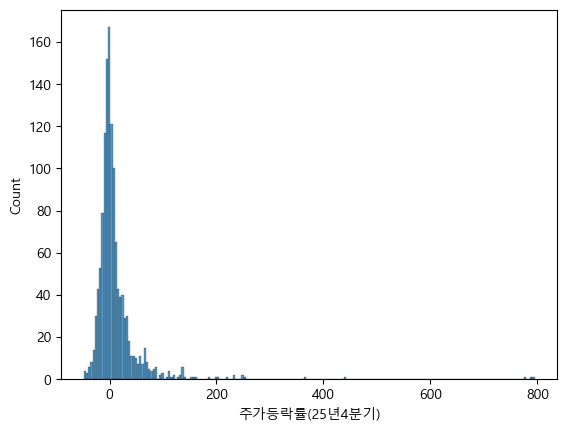

In [25]:
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# 1. 한글 폰트 설정
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')  # 윈도우: 맑은 고딕
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')    # 맥: 애플고딕
else:
    rc('font', family='NanumBarunGothic') # 리눅스(코랩 등)
import seaborn as sns 
sns.histplot(x='RET', data=data_ret)
plt.xlabel('주가등락률(25년4분기)')

In [26]:
data_ret['RET'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    1301.000000
mean       11.333744
std        52.203479
min       -48.267898
10%       -17.474634
25%        -7.904412
50%         0.919540
75%        14.831131
90%        41.575274
max       794.865526
Name: RET, dtype: float64

In [27]:
data_ret.query("RET < 41 & RET > -17 ")

,scode,sname,mom_price,mom_vol,PER,PBR,revenue_rate,oper_income_rate,net_income_rate,ROE,...,밸류_PER,밸류_PBR,퀄러티_ROE,퀄러티_매출증가,퀄러티_영업이익증가,퀄러티_순이익증가,종합점수,종합순위,종합순위_퍼센트,RET
2,015760,한국전력,13.621553,-17.256292,3.55,0.31,25.614006,164.614448,222.169330,19.12,...,6.840892,16.102998,6.917756,6.687164,5.457341,8.224443,15.800346,3.0,0.230592,32.770745
3,105840,우진,27.586931,41.407998,7.72,0.54,36.389685,157.894737,410.000000,6.61,...,24.481168,31.667948,37.586472,4.304381,5.841660,5.149885,16.088586,4.0,0.307456,14.640698
4,002460,HS화성,-1.109531,30.426956,7.30,0.24,154.521964,1308.333333,584.848485,9.48,...,22.751729,10.530361,24.596464,0.384320,0.922367,3.228286,16.948501,5.0,0.384320,17.948718
5,004710,한솔테크닉스,15.284897,295.722081,5.62,0.25,12.942779,38.281250,50.588235,6.15,...,15.718678,11.145273,39.046887,15.372790,19.139124,23.443505,17.971752,6.0,0.461184,-11.976048
6,037460,삼지전자,10.449271,-4.170062,1.50,0.21,10.000000,51.027397,38.461538,16.00,...,1.076095,7.955419,10.261337,18.946964,15.065334,26.787087,18.063028,7.0,0.538048,21.117502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,255220,SG,-3.345960,-16.362968,10.02,2.85,-37.321937,-204.545455,-134.285714,-11.32,...,50.038432,89.046887,89.777095,95.695619,94.850115,86.856264,78.838394,1296.0,99.615680,22.985782
1296,009410,태영건설,-25.321884,-60.396813,5.53,1.35,-9.948572,-119.397993,-252.139037,-5.94,...,15.219062,71.867794,85.703305,80.399693,90.853190,93.620292,79.054573,1297.0,99.692544,11.775939
1297,182360,큐브엔터,-0.240308,-37.761601,13.16,1.36,-9.239130,-677.777778,-400.000000,-0.88,...,76.095311,72.059954,79.169869,78.785550,98.616449,96.502690,79.890469,1298.0,99.769408,-8.637874
1299,424960,스마트레이더시스템,-6.633073,-47.598792,10.02,13.94,-30.769231,-16.666667,-200.000000,-35.71,...,50.038432,98.923905,96.003075,94.542659,64.834743,91.122214,83.560723,1300.0,99.923136,0.477897


In [28]:
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# 1. 한글 폰트 설정
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')  # 윈도우: 맑은 고딕
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')    # 맥: 애플고딕
else:
    rc('font', family='NanumBarunGothic') # 리눅스(코랩 등)

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
def plot_by_factor(df, feat):
    ser = pd.qcut(df[feat], 10, duplicates='drop')  # feat 컬럼별 10개 그룹화 
    print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력 
    df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성
    plt.show()
def plot_by_factor(df, feat):
    ser = pd.qcut(df[feat], 10, duplicates='drop')  # feat 컬럼별 10개 그룹화 
    print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력 
    df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성
    plt.show()


                  size      mean    median
종합순위                                      
(2.999, 126.6]     103  5.662838  4.483431
(126.6, 253.6]     103  5.886826  3.209020
(253.6, 380.4]     103  4.158981  1.855406
(380.4, 509.2]     103  3.123046  1.320132
(509.2, 640.5]     104  3.816544  0.903161
(640.5, 766.8]     101  2.946740  0.207254
(766.8, 895.6]     103  4.648732  1.344538
(895.6, 1032.4]    103  0.173135 -2.380952
(1032.4, 1161.2]   103  4.177144  1.899696
(1161.2, 1301.0]   103  2.462523 -0.499643


C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


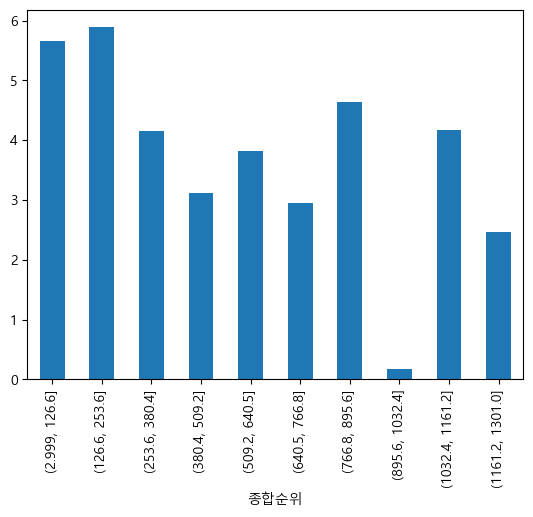

In [29]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '종합순위')

                  size      mean    median
모멘텀_주가                                    
(0.383, 14.512]    103  5.797504  2.309469
(14.512, 24.95]    103  5.025948  3.971119
(24.95, 34.881]    103  4.175110  1.899696
(34.881, 44.673]   103  3.418891  1.095890
(44.673, 53.267]   103  4.470964  2.040816
(53.267, 62.629]   102  3.790519  1.129991
(62.629, 71.683]   103  2.022969  0.902708
(71.683, 81.199]   103  1.282733 -0.495050
(81.199, 90.1]     103  3.876678  1.301301
(90.1, 100.0]      103  3.211830  0.120337


C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


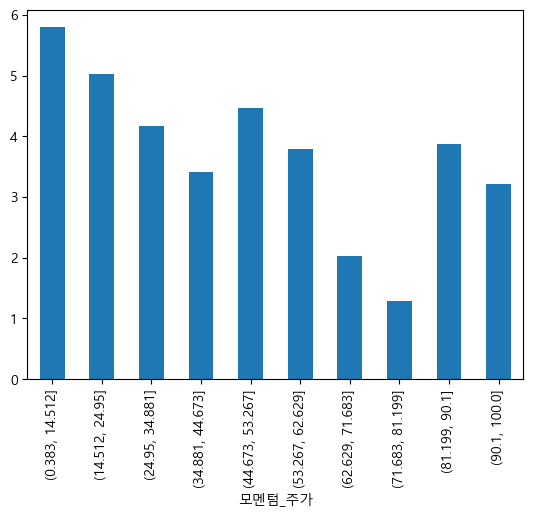

In [30]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '모멘텀_주가')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


                  size      mean    median
모멘텀_거래량                                   
(0.114, 10.73]     103  1.318772 -0.113250
(10.73, 20.646]    103  5.263950  2.168367
(20.646, 30.546]   103  5.964256  2.743142
(30.546, 39.908]   103  2.227196 -0.499643
(39.908, 49.885]   103  2.538165  0.598802
(49.885, 59.477]   102  5.094882  2.192697
(59.477, 69.531]   103  6.042740  2.826855
(69.531, 78.816]   103  2.939702  0.000000
(78.816, 89.331]   103  2.123250 -0.344234
(89.331, 100.0]    103  3.572898  0.000000


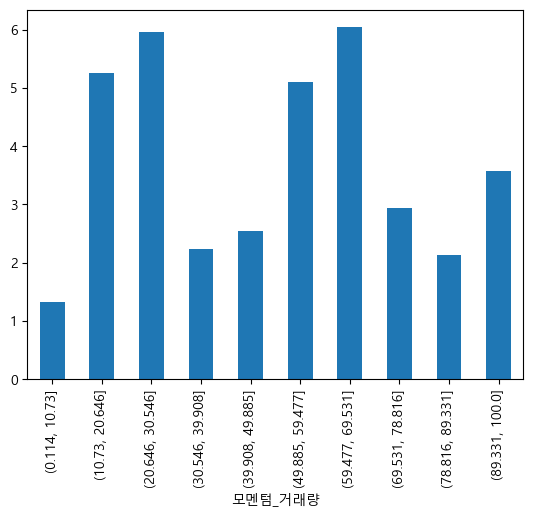

In [31]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '모멘텀_거래량')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


                  size      mean    median
밸류_PER                                    
(0.0759, 8.955]    104  6.419447  3.645726
(8.955, 17.571]    102  4.583630  4.616551
(17.571, 26.856]   103  2.493596  0.919540
(26.856, 50.038]   390  4.172861  1.157021
(50.038, 70.576]    21  7.313874  3.971119
(70.576, 80.123]   103  0.745250 -1.643192
(80.123, 90.177]   103  1.556007 -1.167883
(90.177, 100.0]    103  3.929260 -0.290698


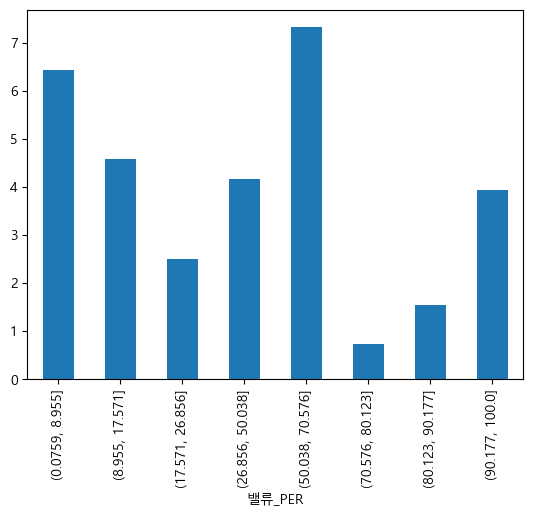

In [32]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '밸류_PER')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


                  size      mean    median
밸류_PBR                                    
(1.114, 9.646]     110  5.714198  3.581821
(9.646, 18.101]     98  4.460193  1.903832
(18.101, 27.294]   101  5.201237  4.245283
(27.294, 37.202]   107  4.583570  0.903614
(37.202, 50.269]   191  2.557650 -0.649351
(50.269, 57.84]     12  5.410816  3.445680
(57.84, 67.294]    102  1.467365 -2.063077
(67.294, 77.617]   102  0.465595 -1.014086
(77.617, 88.271]   103  2.398539 -1.167883
(88.271, 100.0]    103  7.142366  4.534884


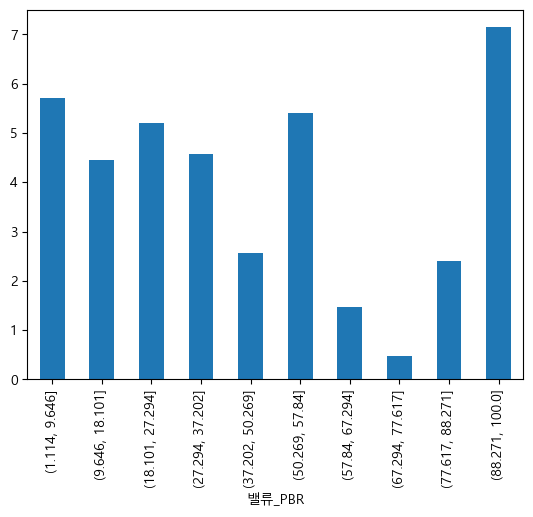

In [33]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '밸류_PBR')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력


                  size      mean    median
퀄러티_ROE                                   
(0.0759, 10.976]   103  3.339774 -1.643192
(10.976, 20.261]   103  5.164202  4.483431
(20.261, 29.37]    103  4.094046  2.134647
(29.37, 38.493]    103  3.729445  2.743142
(38.493, 50.038]   199  2.285618 -1.095618
(50.038, 59.247]     6  4.040479  4.250818
(59.247, 68.793]   104  3.744308  0.740176
(68.793, 78.363]   103  2.531093 -0.330761
(78.363, 87.563]   102  2.858680 -0.657213
(87.563, 100.0]    103  6.914929  3.919598


C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


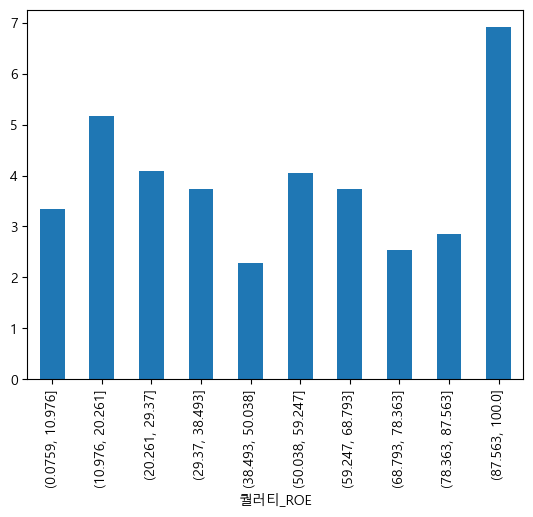

In [34]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '퀄러티_ROE')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


                  size      mean    median
퀄러티_매출증가                                  
(0.153, 11.207]    103  6.286682  5.343511
(11.207, 21.46]    103  4.374569  1.151190
(21.46, 30.776]    103  3.098558  0.579374
(30.776, 40.446]   103  4.729465  1.043478
(40.446, 50.038]   164  2.604621 -0.602453
(50.038, 60.538]    41  3.390994  1.842752
(60.538, 70.146]   103  3.651130  0.163666
(70.146, 79.739]   103  2.657445  0.714286
(79.739, 89.408]   103  2.597500  1.095890
(89.408, 100.0]    103  4.144022  3.448276


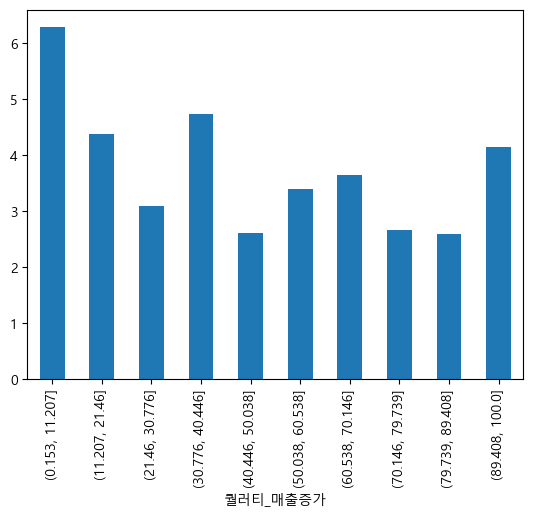

In [35]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '퀄러티_매출증가')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


                  size      mean    median
퀄러티_영업이익증가                                
(0.0759, 10.377]   103  3.695917 -0.113250
(10.377, 20.261]   103  3.826593  1.518027
(20.261, 29.785]   104  4.899218  1.549875
(29.785, 39.439]   102  3.868691  2.133674
(39.439, 50.038]   176  2.991049  0.119617
(50.038, 60.031]    29  6.680910  3.209020
(60.031, 69.762]   103  1.086703  0.744417
(69.762, 79.385]   103  4.371053  1.462396
(79.385, 89.431]   106  4.284722  0.142138
(89.431, 100.0]    100  3.992995  0.349618


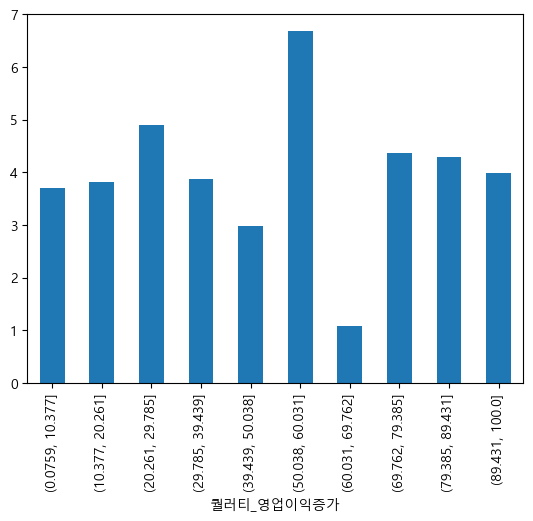

In [36]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '퀄러티_영업이익증가')

C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print( df.groupby(ser)['RET'].agg(['size', 'mean', 'median']) )  # 그룹별 건수, 평균, 중앙값 출력
C:\Users\DrFirst\AppData\Local\Temp\ipykernel_19208\3380479020.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(ser)['RET'].mean().plot(kind='bar') # 그룹별 수익률 평균으로 막대 그래프 생성


                  size      mean    median
퀄러티_순이익증가                                 
(0.0759, 10.438]   103  6.261730  4.712460
(10.438, 19.877]   103  3.249479  0.714286
(19.877, 30.1]     103  3.733370  1.452282
(30.1, 39.508]     104  6.234278  1.894139
(39.508, 50.038]   176  2.607219 -0.179956
(50.038, 59.324]    28  6.799900  4.531052
(59.324, 68.686]   103  2.379916  0.976562
(68.686, 79.001]   103  1.612541 -0.722259
(79.001, 89.562]   103  2.343848 -0.660793
(89.562, 100.0]    103  4.857086  1.269841


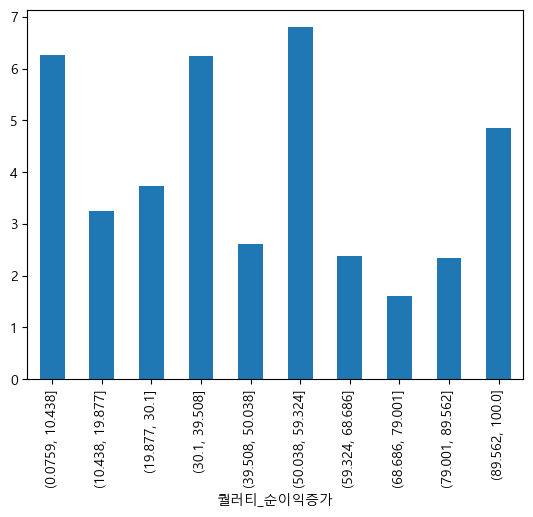

In [37]:
plot_by_factor(data_ret.query("RET < 41 & RET > -17 "), '퀄러티_순이익증가')

In [38]:
ed!# 주가(RET)와 멀티팩터 지표의 상관계수 행렬 생성 
cor = ( data_ret.query("RET < 41 & RET > -17 ")[['RET', '모멘텀_주가', '모멘텀_거래량', '밸류_PER', '밸류_PBR', '퀄러티_ROE', '퀄러티_매출증가', '퀄러티_영업이익증가', '퀄러티_순이익증가']]
                .corr() )

# 상관계수 행렬에서 주가(RET)만 추출 > 상관계수 크기로 정렬 > 막대그래프 생성 
cor['RET'].iloc[1:].sort_values().plot(kind='barh')


SyntaxError: invalid syntax (1907507519.py, line 1)

# 2.4.4 종합지표 최적화하기

In [39]:
# 멀티팩터 지표 컬럼명 정의 
cols = ['모멘텀_주가', '모멘텀_거래량', '밸류_PER', '밸류_PBR', '퀄러티_ROE', '퀄러티_매출증가', '퀄러티_영업이익증가', '퀄러티_순이익증가']

# 가중치 설정 데이터프레임 정의 
df_w = pd.DataFrame()
df_w['cols'] = cols
df_w['weights'] = [0/8, 0/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8]  

# 가중치 데이터프레임 화면 출력 
df_w


,cols,weights
0,모멘텀_주가,0.000
1,모멘텀_거래량,0.000
2,밸류_PER,0.125
3,밸류_PBR,0.125
4,퀄러티_ROE,0.125
5,퀄러티_매출증가,0.125
6,퀄러티_영업이익증가,0.125
7,퀄러티_순이익증가,0.125


In [40]:
# 가중치 적용을 위한 멀티팩터 마스터(data_mast)의 복사본(dat_weight) 생성
data_weight = df_mast.copy() 

# 가중치를 적용하여 종합점수 생성 
data_weight['종합점수'] = np.average( data_weight[cols], axis=1, weights=df_w['weights']) 

# 종합순위 및 종합순위 퍼센트 생성 
data_weight['종합순위'] = data_weight['종합점수'].rank(ascending=True, axis=0)
data_weight['종합순위_퍼센트'] = data_weight['종합순위'] / len(data_weight) * 100 

# 종합순위 순으로 정렬
data_weight.sort_values(by='종합순위', inplace=True)

# 종합순위 상위 10개 종목 화면 출력
data_weight.head(10).T


,324,18,1226,336,857,7,683,497,40,759
scode,124500,015760,002460,007700,079960,402340,037460,072710,267250,170920
sname,아이티센글로벌,한국전력,HS화성,F&F홀딩스,동양이엔피,SK스퀘어,삼지전자,농심홀딩스,HD현대,엘티씨
mom_price,30.263624,13.621553,-1.109531,4.089352,-2.453897,38.208183,10.449271,13.598978,25.79483,41.277362
mom_vol,119.697969,-17.256292,30.426956,-35.266975,9.453679,2.081694,-4.170062,-61.363046,-19.84295,-18.813472
PER,3.34,3.55,7.3,1.47,2.03,2.95,1.5,3.93,3.24,5.97
PBR,0.37,0.31,0.24,0.14,0.34,0.54,0.21,0.24,0.21,0.44
revenue_rate,36.362201,25.614006,154.521964,25.217851,16.997167,62.829,10.0,52.522936,5.888095,10.766721
oper_income_rate,198.611111,164.614448,1308.333333,60.805369,20.740741,88.81593,51.027397,23.243243,49.477566,67.346939
net_income_rate,170.348837,222.16933,584.848485,88.675624,7766.666667,71.543086,38.461538,319.354839,102.233607,400.0
ROE,29.04,19.12,9.48,9.41,17.09,32.66,16.0,8.5,11.13,13.5


In [41]:
# 멀티팩터 지표 컬럼명 정의 
df_w = pd.DataFrame()

# 가중치 설정 데이터프레임 정의 
df_w['cols'] = cols
df_w['weights'] = [1/8, 1/8, 0/8, 0/8, 1/8, 1/8, 1/8, 1/8] 

# 가중치 데이터프레임 화면 출력 
df_w 


,cols,weights
0,모멘텀_주가,0.125
1,모멘텀_거래량,0.125
2,밸류_PER,0.000
3,밸류_PBR,0.000
4,퀄러티_ROE,0.125
5,퀄러티_매출증가,0.125
6,퀄러티_영업이익증가,0.125
7,퀄러티_순이익증가,0.125


In [42]:
# 가중치 적용을 위한 멀티팩터 마스터(data_mast)의 복사본(dat_weight) 생성  
data_weight = data_mast.copy() 

# 가중치를 적용하여 종합점수 생성 
data_weight['종합점수'] = np.average( data_weight[cols], axis=1, weights=df_w['weights']) 

# 종합순위 및 종합순위 퍼센트 생성 
data_weight['종합순위'] = data_weight['종합점수'].rank(ascending=True, axis=0)
data_weight['종합순위_퍼센트'] = data_weight['종합순위'] / len(data_weight) * 100

# 종합순위 순으로 정렬
data_weight.sort_values(by='종합순위', inplace=True)

# 종합순위 상위 10개 종목 화면 출력
data_weight.head(10).T


,324,234,486,7,527,975,378,989,67,880
scode,124500,122870,037270,402340,105840,272110,060250,388050,278470,016880
sname,아이티센글로벌,와이지엔터테인먼트,YG PLUS,SK스퀘어,우진,케이엔제이,NHN KCP,지투파워,에이피알,웅진
mom_price,30.263624,34.209993,25.665026,38.208183,27.586931,35.85011,55.498506,5.864206,89.786521,77.700318
mom_vol,119.697969,36.436261,23.885654,2.081694,41.407998,87.381815,197.71252,51.842298,20.877451,-6.270912
PER,3.34,42.74,114.84,2.95,7.72,10.05,6.3,28.08,17.59,10.02
PBR,0.37,1.41,1.35,0.54,0.54,1.48,1.04,3.21,5.76,0.34
revenue_rate,36.362201,72.410359,44.720497,62.829,36.389685,9.5,5.586964,9.859155,17.760146,16.642755
oper_income_rate,198.611111,217.567568,103.125,88.81593,157.894737,7.692308,27.419355,266.666667,13.593381,47.490347
net_income_rate,170.348837,117.857143,133.333333,71.543086,410.0,108.333333,45.263158,216.666667,12.518854,46.91358
ROE,29.04,10.88,12.69,32.66,6.61,21.27,17.35,12.35,74.34,30.56


In [43]:
# 멀티팩터 지표 컬럼명 정의 
cols = ['모멘텀_주가', '모멘텀_거래량', '밸류_PER', '밸류_PBR', '퀄러티_ROE', '퀄러티_매출증가', '퀄러티_영업이익증가', '퀄러티_순이익증가']

# 가중치 설정 데이터프레임 정의 
df_w = pd.DataFrame()
df_w['cols'] = cols
df_w['weights'] = [1/8, 1/8, 1/8, 1/8, 0/8, 0/8, 0/8, 0/8] 

# 가중치 데이터프레임 화면 출력 
df_w 


,cols,weights
0,모멘텀_주가,0.125
1,모멘텀_거래량,0.125
2,밸류_PER,0.125
3,밸류_PBR,0.125
4,퀄러티_ROE,0.000
5,퀄러티_매출증가,0.000
6,퀄러티_영업이익증가,0.000
7,퀄러티_순이익증가,0.000


In [44]:
# 가중치 적용을 위한 멀티팩터 마스터(data_mast)의 복사본(dat_weight) 생성  
data_weight = data_mast.copy() 

# 가중치를 적용하여 종합점수 생성 
data_weight['종합점수'] = np.average( data_weight[cols], axis=1, weights=df_w['weights']) 

# 종합순위 및 종합순위 퍼센트 생성 
data_weight['종합순위'] = data_weight['종합점수'].rank(ascending=True, axis=0)
data_weight['종합순위_퍼센트'] = data_weight['종합순위'] / len(data_weight) * 100

# 종합순위 순으로 정렬
data_weight.sort_values(by='종합순위', inplace=True)

# 종합순위 상위 10개 종목 화면 출력
data_weight.head(10).T


,974,324,739,904,401,1212,252,264,412,577
scode,000230,124500,210980,004710,002020,021820,071320,376900,119850,008060
sname,일동홀딩스,아이티센글로벌,SK디앤디,한솔테크닉스,코오롱,세원정공,지역난방공사,로킷헬스케어,지엔씨에너지,대덕
mom_price,28.241093,30.263624,11.219454,15.284897,30.246623,11.648107,23.028495,43.303595,90.925992,9.221818
mom_vol,209.231228,119.697969,120.540043,295.722081,-4.387667,16.677172,0.957156,222.916904,32.103719,25.717441
PER,1.69,3.34,3.2,5.62,1.22,2.52,2.28,10.02,3.47,5.39
PBR,0.36,0.37,0.24,0.25,0.08,0.17,0.21,0.0,0.76,0.15
revenue_rate,1.142473,36.362201,-25.381818,12.942779,-4.249235,-35.313531,21.681913,16.666667,14.309211,13.434219
oper_income_rate,-425.0,198.611111,-73.432836,38.28125,55.402299,-2.469136,-1031.25,-3.85566,4.918033,-206.060606
net_income_rate,-275.581395,170.348837,-79.255319,50.588235,-108.79567,-13.664596,-326.851852,20.0,21.649485,-363.529412
ROE,36.48,29.04,10.85,6.15,-7.23,7.41,14.74,23.31,22.29,0.92
